<h1>Time Series</h1>

Time series data is an important form of structured data in many different fields, such as finance, economics, ecology, neuroscience, and physics. Anything that is recorded repeatedly at many points in time forms a time series. Many time series are fixed frequency, which is to say that data points occur at regular intervals according to some rule, such as every 15 seconds, every 5 minutes, or once per month. Time series can also be irregular without a fixed unit of time or offset between units. How you mark and refer to time series data depends on the application, and you may have one of the following:

<b>Timestamps</b><br />
Specific instants in time.

<b>Fixed periods</b><br />
Such as the whole month of January 2017, or the whole year 2020.

<b>Intervals of time</b><br />
Indicated by a start and end timestamp. Periods can be thought of as special cases of intervals.

<b>Experiment or elapsed time</b><br />
Each timestamp is a measure of time relative to a particular start time (e.g., the diameter of a cookie baking each second since being placed in the oven), starting from 0.

In this notebook, I am mainly concerned with time series in the first three categories, though many of the techniques can be applied to experimental time series where the index may be an integer or floating-point number indicating elapsed time from the start of the experiment. The simplest kind of time series is indexed by timestamp.

pandas provides many built-in time series tools and algorithms. You can efficiently work with large time series, and slice and dice, aggregate, and resample irregular- and fixed-frequency time series. Some of these tools are useful for financial and economics applications, but you could certainly use them to analyze server log data, too.

As with the rest of the chapters, we start by importing NumPy and pandas:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

<h1>Date and Time Data Types and Tools</h1>

The Python standard library includes data types for date and time data, as well as calendar-related functionality. The `datetime`, `time`, and `calendar` modules are the main places to start. The `datetime.datetime` type, or simply `datetime`, is widely used:

In [2]:
from datetime import datetime
now = datetime.now()
now

datetime.datetime(2022, 12, 15, 11, 34, 52, 663866)

In [3]:
now.year, now.month, now.day

(2022, 12, 15)

`datetime` stores both the date and time down to the microsecond. `datetime.timedelta`, or simply `timedelta`, represents the temporal difference between two `datetime` objects:

In [4]:
delta = datetime(2011, 1, 7) - datetime(2008, 6, 24, 8, 15)
delta

datetime.timedelta(days=926, seconds=56700)

In [5]:
delta.days

926

In [6]:
delta.seconds

56700

You can add (or subtract) a `timedelta` or multiple thereof to a `datetime` object to yield a new shifted object:

In [7]:
from datetime import timedelta
start = datetime(2011, 1, 7)
start + timedelta(12)

datetime.datetime(2011, 1, 19, 0, 0)

In [8]:
start - 2 * timedelta(12)

datetime.datetime(2010, 12, 14, 0, 0)

Below table summarizes the data types in the `datetime` module. While this chapter is mainly concerned with the data types in pandas and higher-level time series manipulation, you may encounter the `datetime`-based types in many other places in Python in the wild.

<b>Note!</b> Types in the datetime module can be found in the following <a href="https://docs.python.org/3/library/datetime.html">link</a>.

<h2>Converting Between String and Datetime</h2>

You can format `datetime` objects and pandas `Timestamp` objects, which I’ll introduce later, as strings using `str` or the `strftime` method, passing a format specification:

In [9]:
stamp = datetime(2011, 1, 3)
str(stamp)

'2011-01-03 00:00:00'

In [10]:
stamp.strftime("%Y-%m-%d")

'2011-01-03'

<b>Note!</b> Check the following <a href="https://strftime.org/">link</a> for a complete list of the format codes.

You can use many of the same format codes to convert strings to dates using `datetime.strptime` (but some codes, like `%F`, cannot be used):

In [11]:
value = "2011-01-03"
datetime.strptime(value, "%Y-%m-%d")

datetime.datetime(2011, 1, 3, 0, 0)

In [12]:
datestrs = ["7/6/2011", "8/6/2011"]
[datetime.strptime(x, "%m/%d/%Y") for x in datestrs]

[datetime.datetime(2011, 7, 6, 0, 0), datetime.datetime(2011, 8, 6, 0, 0)]

`datetime.strptime` is one way to parse a date with a known format.
pandas is generally oriented toward working with arrays of dates, whether used as an axis index or a column in a DataFrame. The `pandas.to_datetime` method parses many different kinds of date representations. Standard date formats like ISO 8601 can be parsed quickly:

In [13]:
datestrs = ["2011-07-06 12:00:00", "2011-08-06 00:00:00"]
pd.to_datetime(datestrs)

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00'], dtype='datetime64[ns]', freq=None)

It also handles values that should be considered missing (`None`, empty string, etc.):

In [14]:
idx = pd.to_datetime(datestrs + [None])
idx

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00', 'NaT'], dtype='datetime64[ns]', freq=None)

In [15]:
idx[2]

NaT

In [16]:
pd.isna(idx)

array([False, False,  True])

`NaT` (Not a Time) is pandas’s null value for timestamp data.

Danger
`dateutil.parser` is a useful but imperfect tool. Notably, it will recognize some strings as dates that you might prefer that it didn’t; for example, `"42"` will be parsed as the year `2042` with today’s calendar date.

`datetime` objects also have a number of locale-specific formatting options for systems in other countries or languages. For example, the abbreviated month names will be different on German or French systems compared with English systems. See the following <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Period.strftime.html">link</a> for a listing.

<h1>Time Series Basics</h1>

A basic kind of time series object in pandas is a Series indexed by timestamps, which is often represented outside of pandas as Python strings or `datetime` objects:

In [17]:
dates = [datetime(2011, 1, 2), datetime(2011, 1, 5),
         datetime(2011, 1, 7), datetime(2011, 1, 8),
         datetime(2011, 1, 10), datetime(2011, 1, 12)]
ts = pd.Series(np.random.standard_normal(6), index=dates)
ts

2011-01-02    0.065255
2011-01-05   -0.388859
2011-01-07    1.494203
2011-01-08    2.002605
2011-01-10    0.344583
2011-01-12   -0.362164
dtype: float64

Under the hood, these `datetime` objects have been put in a `DatetimeIndex`:

In [18]:
ts.index

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

Like other Series, arithmetic operations between differently indexed time series automatically align on the dates:

In [19]:
ts + ts[::2]

2011-01-02    0.130511
2011-01-05         NaN
2011-01-07    2.988407
2011-01-08         NaN
2011-01-10    0.689165
2011-01-12         NaN
dtype: float64

Recall that `ts[::2]` selects every second element in `ts`.

pandas stores timestamps using NumPy’s `datetime64` data type at the nanosecond resolution:

In [20]:
ts.index.dtype

dtype('<M8[ns]')

Scalar values from a `DatetimeIndex` are pandas `Timestamp` objects:

In [21]:
stamp = ts.index[0]
stamp

Timestamp('2011-01-02 00:00:00')

A `pandas.Timestamp` can be substituted most places where you would use a `datetime` object. The reverse is not true, however, because pandas.Timestamp can store nanosecond precision data, while `datetime` stores only up to microseconds. Additionally, `pandas.Timestamp` can store frequency information (if any) and understands how to do time zone conversions and other kinds of manipulations. More on both of these things later in Time Zone Handling.

<h2>Indexing, Selection, Subsetting</h2>

Time series behaves like any other Series when you are indexing and selecting data based on the label:

In [22]:
stamp = ts.index[2]
ts[stamp]

1.4942033121999354

As a convenience, you can also pass a string that is interpretable as a date:

In [23]:
ts["2011-01-10"]

0.3445825923930551

For longer time series, a year or only a year and month can be passed to easily select slices of data (`pandas.date_range` is discussed in more detail in Generating Date Ranges):

In [24]:
longer_ts = pd.Series(np.random.standard_normal(1000),
                      index=pd.date_range("2000-01-01", periods=1000))
longer_ts

2000-01-01    0.726645
2000-01-02   -0.694885
2000-01-03   -0.264126
2000-01-04   -0.319109
2000-01-05   -0.649811
                ...   
2002-09-22    1.011127
2002-09-23   -0.375084
2002-09-24   -1.343149
2002-09-25   -0.338491
2002-09-26   -0.247533
Freq: D, Length: 1000, dtype: float64

In [25]:
longer_ts["2001"]

2001-01-01   -0.130189
2001-01-02    0.832044
2001-01-03   -1.368418
2001-01-04    0.378379
2001-01-05   -0.324979
                ...   
2001-12-27   -1.825309
2001-12-28    1.814467
2001-12-29   -0.245921
2001-12-30   -0.824845
2001-12-31    0.461648
Freq: D, Length: 365, dtype: float64

Here, the string `"2001"` is interpreted as a year and selects that time period. This also works if you specify the month:

In [26]:
longer_ts["2001-05"]

2001-05-01   -0.502049
2001-05-02    1.025396
2001-05-03    0.378755
2001-05-04    0.115245
2001-05-05   -0.605665
2001-05-06   -1.020814
2001-05-07    1.042949
2001-05-08   -1.247103
2001-05-09    0.552095
2001-05-10   -1.234341
2001-05-11   -1.794921
2001-05-12    0.125680
2001-05-13   -0.403789
2001-05-14   -0.623674
2001-05-15    0.511938
2001-05-16   -0.733172
2001-05-17   -0.554251
2001-05-18   -0.930454
2001-05-19   -2.658583
2001-05-20    0.113442
2001-05-21    0.012631
2001-05-22   -1.085535
2001-05-23   -0.119881
2001-05-24    1.899753
2001-05-25    0.524971
2001-05-26   -1.435732
2001-05-27    0.366907
2001-05-28    0.252091
2001-05-29   -0.050180
2001-05-30   -0.183665
2001-05-31   -0.694421
Freq: D, dtype: float64

Slicing with `datetime` objects works as well:

In [27]:
ts[datetime(2011, 1, 7):]

2011-01-07    1.494203
2011-01-08    2.002605
2011-01-10    0.344583
2011-01-12   -0.362164
dtype: float64

In [28]:
ts[datetime(2011, 1, 7):datetime(2011, 1, 10)]

2011-01-07    1.494203
2011-01-08    2.002605
2011-01-10    0.344583
dtype: float64

Because most time series data is ordered chronologically, you can slice with timestamps not contained in a time series to perform a range query:

In [29]:
ts

2011-01-02    0.065255
2011-01-05   -0.388859
2011-01-07    1.494203
2011-01-08    2.002605
2011-01-10    0.344583
2011-01-12   -0.362164
dtype: float64

In [30]:
ts["2011-01-06":"2011-01-11"]

2011-01-07    1.494203
2011-01-08    2.002605
2011-01-10    0.344583
dtype: float64

As before, you can pass a string date, `datetime`, or timestamp. Remember that slicing in this manner produces views on the source time series, like slicing NumPy arrays. This means that no data is copied, and modifications on the slice will be reflected in the original data.

There is an equivalent instance method, `truncate`, that slices a Series between two dates:

In [31]:
ts.truncate(after="2011-01-09")

2011-01-02    0.065255
2011-01-05   -0.388859
2011-01-07    1.494203
2011-01-08    2.002605
dtype: float64

All of this holds true for DataFrame as well, indexing on its rows:

In [32]:
dates = pd.date_range("2000-01-01", periods=100, freq="W-WED")
long_df = pd.DataFrame(np.random.standard_normal((100, 4)),
                       index=dates,
                       columns=["Colorado", "Texas",
                                "New York", "Ohio"])
long_df.loc["2001-05"]

,Colorado,Texas,New York,Ohio
2001-05-02,-0.343207,-1.885636,0.391259,0.717115
2001-05-09,0.021654,2.028127,-0.057161,-0.155740
2001-05-16,0.807232,-0.060733,-1.159967,-0.197945
2001-05-23,-0.496283,-1.842984,1.045167,-2.044364
2001-05-30,-0.839724,-2.163801,-0.844285,-0.428417


<h2>Time Series with Duplicate Indices</h2>

In some applications, there may be multiple data observations falling on a particular timestamp.
Here is an example:

In [33]:
dates = pd.DatetimeIndex(["2000-01-01", "2000-01-02", "2000-01-02",
                          "2000-01-02", "2000-01-03"])
dup_ts = pd.Series(np.arange(5), index=dates)
dup_ts

2000-01-01    0
2000-01-02    1
2000-01-02    2
2000-01-02    3
2000-01-03    4
dtype: int32

We can tell that the index is not unique by checking its `is_unique` property:

In [34]:
dup_ts.index.is_unique

False

Indexing into this time series will now either produce scalar values or slices, depending on whether a timestamp is duplicated:

In [35]:
dup_ts["2000-01-03"]  # not duplicated

4

In [36]:
dup_ts["2000-01-02"]  # duplicated

2000-01-02    1
2000-01-02    2
2000-01-02    3
dtype: int32

Suppose you wanted to aggregate the data having nonunique timestamps. One way to do this is to use `groupby` and pass `level=0` (the one and only level):

In [37]:
grouped = dup_ts.groupby(level=0)
grouped.mean()

2000-01-01    0.0
2000-01-02    2.0
2000-01-03    4.0
dtype: float64

In [38]:
grouped.count()

2000-01-01    1
2000-01-02    3
2000-01-03    1
dtype: int64

<h1>Date Ranges, Frequencies, and Shifting</h1>

Generic time series in pandas are assumed to be irregular; that is, they have no fixed frequency. For many applications this is sufficient. However, it’s often desirable to work relative to a fixed frequency, such as daily, monthly, or every 15 minutes, even if that means introducing missing values into a time series. Fortunately, pandas has a full suite of standard time series frequencies and tools for resampling (discussed in more detail later in Resampling and Frequency Conversion), inferring frequencies, and generating fixed-frequency date ranges. For example, you can convert the sample time series to fixed daily frequency by calling `resample`:

In [39]:
ts

2011-01-02    0.065255
2011-01-05   -0.388859
2011-01-07    1.494203
2011-01-08    2.002605
2011-01-10    0.344583
2011-01-12   -0.362164
dtype: float64

In [40]:
resampler = ts.resample("D")
resampler

The string `"D"` is interpreted as daily frequency.

Conversion between frequencies or resampling is a big enough topic to have its own section later (Resampling and Frequency Conversion). Here, I’ll show you how to use the base frequencies and multiples thereof.

<h2>Generating Date Ranges</h2>

While I used it previously without explanation, `pandas.date_range` is responsible for generating a `DatetimeIndex` with an indicated length according to a particular frequency:

In [41]:
index = pd.date_range("2012-04-01", "2012-06-01")
index

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20',
               '2012-04-21', '2012-04-22', '2012-04-23', '2012-04-24',
               '2012-04-25', '2012-04-26', '2012-04-27', '2012-04-28',
               '2012-04-29', '2012-04-30', '2012-05-01', '2012-05-02',
               '2012-05-03', '2012-05-04', '2012-05-05', '2012-05-06',
               '2012-05-07', '2012-05-08', '2012-05-09', '2012-05-10',
               '2012-05-11', '2012-05-12', '2012-05-13', '2012-05-14',
               '2012-05-15', '2012-05-16', '2012-05-17', '2012-05-18',
               '2012-05-19', '2012-05-20', '2012-05-21', '2012-05-22',
               '2012-05-23', '2012-05-24', '2012-05-25', '2012-05-26',
      

By default, `pandas.date_range` generates daily timestamps. If you pass only a start or end date, you must pass a number of periods to generate:

In [42]:
pd.date_range(start="2012-04-01", periods=20)

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20'],
              dtype='datetime64[ns]', freq='D')

In [43]:
pd.date_range(end="2012-06-01", periods=20)

DatetimeIndex(['2012-05-13', '2012-05-14', '2012-05-15', '2012-05-16',
               '2012-05-17', '2012-05-18', '2012-05-19', '2012-05-20',
               '2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-26', '2012-05-27', '2012-05-28',
               '2012-05-29', '2012-05-30', '2012-05-31', '2012-06-01'],
              dtype='datetime64[ns]', freq='D')

The start and end dates define strict boundaries for the generated date index. For example, if you wanted a date index containing the last business day of each month, you would pass the `"BM"` frequency (business end of month; see a more complete listing of frequencies <a href="https://pandas.pydata.org/docs/user_guide/timeseries.html">here</a>), and only dates falling on or inside the date interval will be included:

In [44]:
pd.date_range("2000-01-01", "2000-12-01", freq="BM")

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-28',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-29', '2000-10-31', '2000-11-30'],
              dtype='datetime64[ns]', freq='BM')

`pandas.date_range` by default preserves the time (if any) of the start or end timestamp:

In [45]:
pd.date_range("2012-05-02 12:56:31", periods=5)

DatetimeIndex(['2012-05-02 12:56:31', '2012-05-03 12:56:31',
               '2012-05-04 12:56:31', '2012-05-05 12:56:31',
               '2012-05-06 12:56:31'],
              dtype='datetime64[ns]', freq='D')

Sometimes you will have start or end dates with time information but want to generate a set of timestamps normalized to midnight as a convention. To do this, there is a `normalize` option:

In [46]:
pd.date_range("2012-05-02 12:56:31", periods=5, normalize=True)

DatetimeIndex(['2012-05-02', '2012-05-03', '2012-05-04', '2012-05-05',
               '2012-05-06'],
              dtype='datetime64[ns]', freq='D')

<h2>Frequencies and Date Offsets</h2>

Frequencies in pandas are composed of a base frequency and a multiplier. Base frequencies are typically referred to by a string alias, like `"M"` for monthly or `"H"` for hourly. For each base frequency, there is an object referred to as a date offset. For example, hourly frequency can be represented with the `Hour` class:

In [47]:
from pandas.tseries.offsets import Hour, Minute

hour = Hour()
hour

<Hour>

You can define a multiple of an offset by passing an integer:

In [48]:
four_hours = Hour(4)
four_hours

<4 * Hours>

In most applications, you would never need to explicitly create one of these objects; instead you'd use a string alias like `"H"` or `"4H"`. Putting an integer before the base frequency creates a multiple:

In [49]:
pd.date_range("2000-01-01", "2000-01-03 23:59", freq="4H")

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 04:00:00',
               '2000-01-01 08:00:00', '2000-01-01 12:00:00',
               '2000-01-01 16:00:00', '2000-01-01 20:00:00',
               '2000-01-02 00:00:00', '2000-01-02 04:00:00',
               '2000-01-02 08:00:00', '2000-01-02 12:00:00',
               '2000-01-02 16:00:00', '2000-01-02 20:00:00',
               '2000-01-03 00:00:00', '2000-01-03 04:00:00',
               '2000-01-03 08:00:00', '2000-01-03 12:00:00',
               '2000-01-03 16:00:00', '2000-01-03 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

Many offsets can be combined by addition:

In [50]:
Hour(2) + Minute(30)

<150 * Minutes>

Similarly, you can pass frequency strings, like `"1h30min"`, that will effectively be parsed to the same expression:

In [51]:
pd.date_range("2000-01-01", periods=10, freq="1h30min")

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:30:00',
               '2000-01-01 03:00:00', '2000-01-01 04:30:00',
               '2000-01-01 06:00:00', '2000-01-01 07:30:00',
               '2000-01-01 09:00:00', '2000-01-01 10:30:00',
               '2000-01-01 12:00:00', '2000-01-01 13:30:00'],
              dtype='datetime64[ns]', freq='90T')

### Week of month dates

One useful frequency class is “week of month,” starting with `WOM`. This enables you to get dates like the third Friday of each month:

In [52]:
monthly_dates = pd.date_range("2012-01-01", "2012-09-01", freq="WOM-3FRI")
list(monthly_dates)

[Timestamp('2012-01-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-02-17 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-03-16 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-04-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-05-18 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-06-15 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-07-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-08-17 00:00:00', freq='WOM-3FRI')]

<h2>Shifting (Leading and Lagging) Data</h2>

Shifting refers to moving data backward and forward through time. Both Series and DataFrame have a `shift` method for doing naive shifts forward or backward, leaving the index unmodified:

In [53]:
ts = pd.Series(np.random.standard_normal(4),
               index=pd.date_range("2000-01-01", periods=4, freq="M"))
ts

2000-01-31   -0.063800
2000-02-29    1.337065
2000-03-31   -0.144361
2000-04-30    0.048466
Freq: M, dtype: float64

In [54]:
ts.shift(2)

2000-01-31         NaN
2000-02-29         NaN
2000-03-31   -0.063800
2000-04-30    1.337065
Freq: M, dtype: float64

In [55]:
ts.shift(-2)

2000-01-31   -0.144361
2000-02-29    0.048466
2000-03-31         NaN
2000-04-30         NaN
Freq: M, dtype: float64

When we shift like this, missing data is introduced either at the start or the end of the time series.

A common use of `shift` is computing consecutive percent changes in a time series or multiple time series as DataFrame columns. This is expressed as:

In [56]:
ts.shift(1) - 1

2000-01-31         NaN
2000-02-29   -1.063800
2000-03-31    0.337065
2000-04-30   -1.144361
Freq: M, dtype: float64

In [57]:
ts / ts.shift(1) - 1

2000-01-31          NaN
2000-02-29   -21.957238
2000-03-31    -1.107968
2000-04-30    -1.335727
Freq: M, dtype: float64

Because naive shifts leave the index unmodified, some data is discarded. Thus if the frequency is known, it can be passed to `shift` to advance the timestamps instead of simply the data:

In [58]:
ts.shift(2, freq="M")

2000-03-31   -0.063800
2000-04-30    1.337065
2000-05-31   -0.144361
2000-06-30    0.048466
Freq: M, dtype: float64

Other frequencies can be passed, too, giving you some flexibility in how to lead and lag the data:

In [59]:
ts.shift(3, freq="D")

2000-02-03   -0.063800
2000-03-03    1.337065
2000-04-03   -0.144361
2000-05-03    0.048466
dtype: float64

In [60]:
ts.shift(1, freq="90T")

2000-01-31 01:30:00   -0.063800
2000-02-29 01:30:00    1.337065
2000-03-31 01:30:00   -0.144361
2000-04-30 01:30:00    0.048466
dtype: float64

The `T` here stands for minutes. Note that the `freq` parameter here indicates the offset to apply to the timestamps, but it does not change the underlying frequency of the data, if any.

<h3>Shifting dates with offsets</h3>

The pandas date offsets can also be used with `datetime` or `Timestamp` objects:

In [61]:
from pandas.tseries.offsets import Day, MonthEnd
now = datetime(2011, 11, 17)
now + 3 * Day()

Timestamp('2011-11-20 00:00:00')

If you add an anchored offset like `MonthEnd`, the first increment will "roll forward" a date to the next date according to the frequency rule:

In [62]:
now + MonthEnd()

Timestamp('2011-11-30 00:00:00')

In [63]:
now + MonthEnd(2)

Timestamp('2011-12-31 00:00:00')

Anchored offsets can explicitly “roll” dates forward or backward by simply using their `rollforward` and `rollback` methods, respectively:

In [64]:
offset = MonthEnd()
offset.rollforward(now)

Timestamp('2011-11-30 00:00:00')

In [65]:
offset.rollback(now)

Timestamp('2011-10-31 00:00:00')

A creative use of date offsets is to use these methods with `groupby`:

In [66]:
ts = pd.Series(np.random.standard_normal(20),
               index=pd.date_range("2000-01-15", periods=20, freq="4D"))
ts

2000-01-15    0.381423
2000-01-19   -1.309117
2000-01-23   -0.290514
2000-01-27    0.248736
2000-01-31   -0.997396
2000-02-04   -0.181317
2000-02-08   -1.032423
2000-02-12   -1.773315
2000-02-16   -0.364227
2000-02-20    0.854665
2000-02-24    2.706682
2000-02-28    0.279614
2000-03-03    0.200480
2000-03-07    0.706843
2000-03-11   -0.752333
2000-03-15   -0.389000
2000-03-19   -0.096518
2000-03-23    1.058742
2000-03-27   -0.431136
2000-03-31   -1.432947
Freq: 4D, dtype: float64

In [67]:
ts.groupby(MonthEnd().rollforward).mean()

2000-01-31   -0.393374
2000-02-29    0.069954
2000-03-31   -0.141984
dtype: float64

Of course, an easier and faster way to do this is with `resample` (we'll discuss this in much more depth in Resampling and Frequency Conversion):

In [68]:
ts.resample("M").mean()

2000-01-31   -0.393374
2000-02-29    0.069954
2000-03-31   -0.141984
Freq: M, dtype: float64

<h1>Time Zone Handling</h1>

Working with time zones can be one of the most unpleasant parts of time series manipulation. As a result, many time series users choose to work with time series in coordinated universal time or UTC, which is the geography-independent international standard. Time zones are expressed as offsets from UTC; for example, New York is four hours behind UTC during daylight saving time (DST) and five hours behind the rest of the year.

In Python, time zone information comes from the third-party `pytz` library (installable with pip or conda), which exposes the Olson database, a compilation of world time zone information. This is especially important for historical data because the DST transition dates (and even UTC offsets) have been changed numerous times depending on the regional laws. In the United States, the DST transition times have been changed many times since 1900!

For detailed information about the `pytz` library, you’ll need to look at that library’s documentation. As far as this book is concerned, pandas wraps `pytz’s` functionality so you can ignore its API outside of the time zone names. Since pandas has a hard dependency on `pytz`, it isn't necessary to install it separately. Time zone names can be found interactively and in the docs:

In [69]:
import pytz

pytz.common_timezones[-5:]

['US/Eastern', 'US/Hawaii', 'US/Mountain', 'US/Pacific', 'UTC']

To get a time zone object from `pytz`, use `pytz.timezone`:

In [70]:
tz = pytz.timezone("America/New_York")
tz

<DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>

Methods in pandas will accept either time zone names or these objects.

<h2>Time Zone Localization and Conversion</h2>

By default, time series in pandas are time zone naive. For example, consider the following time series:

In [71]:
dates = pd.date_range("2012-03-09 09:30", periods=6)
ts = pd.Series(np.random.standard_normal(len(dates)), index=dates)
ts

2012-03-09 09:30:00   -0.756682
2012-03-10 09:30:00    1.164077
2012-03-11 09:30:00    1.495091
2012-03-12 09:30:00    1.416800
2012-03-13 09:30:00   -0.989019
2012-03-14 09:30:00    0.774898
Freq: D, dtype: float64

The index’s `tz` field is `None`:

In [72]:
print(ts.index.tz)

None


Date ranges can be generated with a time zone set:

In [73]:
pd.date_range("2012-03-09 09:30", periods=10, tz="UTC")

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00', '2012-03-16 09:30:00+00:00',
               '2012-03-17 09:30:00+00:00', '2012-03-18 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

Conversion from naive to localized (reinterpreted as having been observed in a particular time zone) is handled by the `tz_localize` method:

In [74]:
ts

2012-03-09 09:30:00   -0.756682
2012-03-10 09:30:00    1.164077
2012-03-11 09:30:00    1.495091
2012-03-12 09:30:00    1.416800
2012-03-13 09:30:00   -0.989019
2012-03-14 09:30:00    0.774898
Freq: D, dtype: float64

In [75]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-09 09:30:00+00:00   -0.756682
2012-03-10 09:30:00+00:00    1.164077
2012-03-11 09:30:00+00:00    1.495091
2012-03-12 09:30:00+00:00    1.416800
2012-03-13 09:30:00+00:00   -0.989019
2012-03-14 09:30:00+00:00    0.774898
Freq: D, dtype: float64

In [76]:
ts_utc.index

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

Once a time series has been localized to a particular time zone, it can be converted to another time zone with `tz_convert`:

In [77]:
ts_utc.tz_convert("America/New_York")

2012-03-09 04:30:00-05:00   -0.756682
2012-03-10 04:30:00-05:00    1.164077
2012-03-11 05:30:00-04:00    1.495091
2012-03-12 05:30:00-04:00    1.416800
2012-03-13 05:30:00-04:00   -0.989019
2012-03-14 05:30:00-04:00    0.774898
Freq: D, dtype: float64

In the case of the preceding time series, which straddles a DST transition in the `America/New_York `time zone, we could localize to US Eastern time and convert to, say, UTC or Berlin time:

In [78]:
ts_eastern = ts.tz_localize("America/New_York")
ts_eastern

2012-03-09 09:30:00-05:00   -0.756682
2012-03-10 09:30:00-05:00    1.164077
2012-03-11 09:30:00-04:00    1.495091
2012-03-12 09:30:00-04:00    1.416800
2012-03-13 09:30:00-04:00   -0.989019
2012-03-14 09:30:00-04:00    0.774898
dtype: float64

In [79]:
ts_eastern.tz_convert("UTC")

2012-03-09 14:30:00+00:00   -0.756682
2012-03-10 14:30:00+00:00    1.164077
2012-03-11 13:30:00+00:00    1.495091
2012-03-12 13:30:00+00:00    1.416800
2012-03-13 13:30:00+00:00   -0.989019
2012-03-14 13:30:00+00:00    0.774898
dtype: float64

In [80]:
ts_eastern.tz_convert("Europe/Berlin")

2012-03-09 15:30:00+01:00   -0.756682
2012-03-10 15:30:00+01:00    1.164077
2012-03-11 14:30:00+01:00    1.495091
2012-03-12 14:30:00+01:00    1.416800
2012-03-13 14:30:00+01:00   -0.989019
2012-03-14 14:30:00+01:00    0.774898
dtype: float64

`tz_localize` and `tz_convert` are also instance methods on `DatetimeIndex`:

In [81]:
ts.index.tz_localize("Asia/Shanghai")

DatetimeIndex(['2012-03-09 09:30:00+08:00', '2012-03-10 09:30:00+08:00',
               '2012-03-11 09:30:00+08:00', '2012-03-12 09:30:00+08:00',
               '2012-03-13 09:30:00+08:00', '2012-03-14 09:30:00+08:00'],
              dtype='datetime64[ns, Asia/Shanghai]', freq=None)

<h2>Operations with Time Zone-Aware Timestamp Objects</h2>

Similar to time series and date ranges, individual `Timestamp` objects similarly can be localized from naive to time zone-aware and converted from one time zone to another:

In [82]:
stamp = pd.Timestamp("2011-03-12 04:00")
stamp_utc = stamp.tz_localize("utc")
stamp_utc.tz_convert("America/New_York")

Timestamp('2011-03-11 23:00:00-0500', tz='America/New_York')

You can also pass a time zone when creating the `Timestamp`:

In [83]:
stamp_moscow = pd.Timestamp("2011-03-12 04:00", tz="Europe/Moscow")
stamp_moscow

Timestamp('2011-03-12 04:00:00+0300', tz='Europe/Moscow')

Time zone-aware `Timestamp` objects internally store a UTC timestamp value as nanoseconds since the Unix epoch (January 1, 1970), so changing the time zone does not alter the internal UTC value:

In [84]:
stamp_utc.value

1299902400000000000

In [85]:
stamp_utc.tz_convert("America/New_York").value

1299902400000000000

When performing time arithmetic using pandas’s `DateOffset` objects, pandas respects daylight saving time transitions where possible. Here we construct timestamps that occur right before DST transitions (forward and backward). First, 30 minutes before transitioning to DST:

In [86]:
stamp = pd.Timestamp("2012-03-11 01:30", tz="US/Eastern")
stamp

Timestamp('2012-03-11 01:30:00-0500', tz='US/Eastern')

In [87]:
stamp + Hour()

Timestamp('2012-03-11 03:30:00-0400', tz='US/Eastern')

Then, 90 minutes before transitioning out of DST:

In [88]:
stamp = pd.Timestamp("2012-11-04 00:30", tz="US/Eastern")
stamp

Timestamp('2012-11-04 00:30:00-0400', tz='US/Eastern')

In [89]:
stamp + 2 * Hour()

Timestamp('2012-11-04 01:30:00-0500', tz='US/Eastern')

<h2>Operations Between Different Time Zones</h2>

If two time series with different time zones are combined, the result will be UTC. Since the timestamps are stored under the hood in UTC, this is a straightforward operation and requires no conversion:

In [90]:
dates = pd.date_range("2012-03-07 09:30", periods=10, freq="B")
ts = pd.Series(np.random.standard_normal(len(dates)), index=dates)
ts

2012-03-07 09:30:00    0.130089
2012-03-08 09:30:00   -1.298839
2012-03-09 09:30:00   -1.293084
2012-03-12 09:30:00   -0.712699
2012-03-13 09:30:00   -1.404430
2012-03-14 09:30:00    1.305841
2012-03-15 09:30:00   -0.728165
2012-03-16 09:30:00   -0.936670
2012-03-19 09:30:00   -0.101140
2012-03-20 09:30:00   -0.137218
Freq: B, dtype: float64

In [91]:
ts1 = ts[:7].tz_localize("Europe/London")
ts2 = ts1[2:].tz_convert("Europe/Moscow")
result = ts1 + ts2
result.index

DatetimeIndex(['2012-03-07 09:30:00+00:00', '2012-03-08 09:30:00+00:00',
               '2012-03-09 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

Operations between time zone-naive and time zone-aware data are not supported and will raise an exception.

<h1>Periods and Period Arithmetic</h1>

Periods represent time spans, like days, months, quarters, or years. The `pandas.Period` class represents this data type, requiring a string or integer and a supported frequency from Table 11.4:

In [92]:
p = pd.Period("2011", freq="A-DEC")
p

Period('2011', 'A-DEC')

In this case, the `Period` object represents the full time span from January 1, 2011, to December 31, 2011, inclusive. Conveniently, adding and subtracting integers from periods has the effect of shifting their frequency:

In [93]:
p + 5

Period('2016', 'A-DEC')

In [94]:
p - 2

Period('2009', 'A-DEC')

If two periods have the same frequency, their difference is the number of units between them as a date offset:

In [95]:
pd.Period("2014", freq="A-DEC") - p

<3 * YearEnds: month=12>

Regular ranges of periods can be constructed with the `period_range` function:

In [96]:
periods = pd.period_range("2000-01-01", "2000-06-30", freq="M")
periods

PeriodIndex(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06'], dtype='period[M]')

The `PeriodIndex` class stores a sequence of periods and can serve as an axis index in any pandas data structure:

In [97]:
pd.Series(np.random.standard_normal(6), index=periods)

2000-01   -1.066135
2000-02    0.022292
2000-03   -0.754072
2000-04   -0.491961
2000-05   -0.848789
2000-06   -1.397406
Freq: M, dtype: float64

If you have an array of strings, you can also use the `PeriodIndex` class, where all of its values are periods:

In [98]:
values = ["2001Q3", "2002Q2", "2003Q1"]
index = pd.PeriodIndex(values, freq="Q-DEC")
index

PeriodIndex(['2001Q3', '2002Q2', '2003Q1'], dtype='period[Q-DEC]')

<h2>Period Frequency Conversion</h2>

Periods and `PeriodIndex` objects can be converted to another frequency with their `asfreq` method. As an example, suppose we had an annual period and wanted to convert it into a monthly period either at the start or end of the year. This can be done like so:

In [99]:
p = pd.Period("2011", freq="A-DEC")
p

Period('2011', 'A-DEC')

In [100]:
p.asfreq("M", how="start")

Period('2011-01', 'M')

In [101]:
p.asfreq("M", how="end")

Period('2011-12', 'M')

In [102]:
p.asfreq("M")

Period('2011-12', 'M')

You can think of `Period("2011", "A-DEC")` as being a sort of cursor pointing to a span of time, subdivided by monthly periods. See Figure 11.1 for an illustration of this. For a fiscal year ending on a month other than December, the corresponding monthly subperiods are different:

In [103]:
p = pd.Period("2011", freq="A-JUN")
p

Period('2011', 'A-JUN')

In [104]:
p.asfreq("M", how="start")

Period('2010-07', 'M')

In [105]:
p.asfreq("M", how="end")

Period('2011-06', 'M')

figueeeeeeeeeee

When you are converting from high to low frequency, pandas determines the subperiod, depending on where the superperiod “belongs.” For example, in `A-JUN` frequency, the month `Aug-2011` is actually part of the `2012` period:

In [106]:
p = pd.Period("Aug-2011", "M")
p.asfreq("A-JUN")

Period('2012', 'A-JUN')

Whole `PeriodIndex` objects or time series can be similarly converted with the same semantics:

In [107]:
periods = pd.period_range("2006", "2009", freq="A-DEC")
ts = pd.Series(np.random.standard_normal(len(periods)), index=periods)
ts

2006   -1.763962
2007   -0.710297
2008   -2.212750
2009   -0.083617
Freq: A-DEC, dtype: float64

In [108]:
ts.asfreq("M", how="start")

2006-01   -1.763962
2007-01   -0.710297
2008-01   -2.212750
2009-01   -0.083617
Freq: M, dtype: float64

Here, the annual periods are replaced with monthly periods corresponding to the first month falling within each annual period. If we instead wanted the last business day of each year, we can use the `"B"` frequency and indicate that we want the end of the period:

In [109]:
ts.asfreq("B", how="end")

2006-12-29   -1.763962
2007-12-31   -0.710297
2008-12-31   -2.212750
2009-12-31   -0.083617
Freq: B, dtype: float64

<h2>Quarterly Period Frequencies</h2>

Quarterly data is standard in accounting, finance, and other fields. Much quarterly data is reported relative to a fiscal year end, typically the last calendar or business day of one of the 12 months of the year. Thus, the period `2012Q4` has a different meaning depending on fiscal year end. pandas supports all 12 possible quarterly frequencies as `Q-JAN` through `Q-DEC`:

In [110]:
p = pd.Period("2012Q4", freq="Q-JAN")
p

Period('2012Q4', 'Q-JAN')

In the case of a fiscal year ending in January, `2012Q4` runs from November 2011 through January 2012, which you can check by converting to daily frequency:

In [111]:
p.asfreq("D", how="start")

Period('2011-11-01', 'D')

In [112]:
p.asfreq("D", how="end")

Period('2012-01-31', 'D')

See Figure 11.2 for an illustration.////////////////////////////

Thus, it’s possible to do convenient period arithmetic; for example, to get the timestamp at 4 P.M. on the second-to-last business day of the quarter, you could do:

In [113]:
p4pm = (p.asfreq("B", how="end") - 1).asfreq("T", how="start") + 16 * 60
p4pm

Period('2012-01-30 16:00', 'T')

In [114]:
p4pm.to_timestamp()

Timestamp('2012-01-30 16:00:00')

The `to_timestamp` method returns the `Timestamp` at the start of the period by default.

You can generate quarterly ranges using `pandas.period_range`. The arithmetic is identical, too:

In [115]:
periods = pd.period_range("2011Q3", "2012Q4", freq="Q-JAN")
ts = pd.Series(np.arange(len(periods)), index=periods)
ts

2011Q3    0
2011Q4    1
2012Q1    2
2012Q2    3
2012Q3    4
2012Q4    5
Freq: Q-JAN, dtype: int32

In [116]:
new_periods = (periods.asfreq("B", "end") - 1).asfreq("H", "start") + 16
ts.index = new_periods.to_timestamp()
ts

2010-10-28 16:00:00    0
2011-01-28 16:00:00    1
2011-04-28 16:00:00    2
2011-07-28 16:00:00    3
2011-10-28 16:00:00    4
2012-01-30 16:00:00    5
dtype: int32

<h2>Converting Timestamps to Periods (and Back)</h2>

Series and DataFrame objects indexed by timestamps can be converted to periods with the `to_period` method:

In [117]:
dates = pd.date_range("2000-01-01", periods=3, freq="M")
ts = pd.Series(np.random.standard_normal(3), index=dates)
ts

2000-01-31   -1.425900
2000-02-29   -0.425117
2000-03-31    0.943160
Freq: M, dtype: float64

In [118]:
pts = ts.to_period()
pts

2000-01   -1.425900
2000-02   -0.425117
2000-03    0.943160
Freq: M, dtype: float64

Since periods refer to nonoverlapping time spans, a timestamp can only belong to a single period for a given frequency. While the frequency of the new `PeriodIndex` is inferred from the timestamps by default, you can specify any supported frequency (most of those listed in Table 11.4 are supported). There is also no problem with having duplicate periods in the result:

In [119]:
dates = pd.date_range("2000-01-29", periods=6)
ts2 = pd.Series(np.random.standard_normal(6), index=dates)
ts2

2000-01-29    1.199968
2000-01-30    1.790025
2000-01-31    0.571799
2000-02-01   -0.659450
2000-02-02    1.162824
2000-02-03    0.278788
Freq: D, dtype: float64

In [120]:
ts2.to_period("M")

2000-01    1.199968
2000-01    1.790025
2000-01    0.571799
2000-02   -0.659450
2000-02    1.162824
2000-02    0.278788
Freq: M, dtype: float64

To convert back to timestamps, use the `to_timestamp` method, which returns a `DatetimeIndex`:

In [121]:
pts = ts2.to_period()
pts

2000-01-29    1.199968
2000-01-30    1.790025
2000-01-31    0.571799
2000-02-01   -0.659450
2000-02-02    1.162824
2000-02-03    0.278788
Freq: D, dtype: float64

In [122]:
pts.to_timestamp(how="end")

2000-01-29 23:59:59.999999999    1.199968
2000-01-30 23:59:59.999999999    1.790025
2000-01-31 23:59:59.999999999    0.571799
2000-02-01 23:59:59.999999999   -0.659450
2000-02-02 23:59:59.999999999    1.162824
2000-02-03 23:59:59.999999999    0.278788
Freq: D, dtype: float64

<h2>Creating a PeriodIndex from Arrays</h2>

Fixed frequency datasets are sometimes stored with time span information spread across multiple columns. For example, in this macroeconomic dataset, the year and quarter are in different columns:

In [123]:
data = pd.read_csv("../data/macrodata.csv")
data.head(5)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [124]:
data["year"]

0      1959
1      1959
2      1959
3      1959
4      1960
       ... 
198    2008
199    2008
200    2009
201    2009
202    2009
Name: year, Length: 203, dtype: int64

In [125]:
data["quarter"]

0      1
1      2
2      3
3      4
4      1
      ..
198    3
199    4
200    1
201    2
202    3
Name: quarter, Length: 203, dtype: int64

By passing these arrays to `PeriodIndex` with a frequency, you can combine them to form an index for the DataFrame:

In [126]:
index = pd.PeriodIndex(year=data["year"], quarter=data["quarter"], freq="Q-DEC")

index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', length=203)

In [127]:
data.index = index
data["infl"]

1959Q1    0.00
1959Q2    2.34
1959Q3    2.74
1959Q4    0.27
1960Q1    2.31
          ... 
2008Q3   -3.16
2008Q4   -8.79
2009Q1    0.94
2009Q2    3.37
2009Q3    3.56
Freq: Q-DEC, Name: infl, Length: 203, dtype: float64

<h1>Resampling and Frequency Conversion</h1>

Resampling refers to the process of converting a time series from one frequency to another. Aggregating higher frequency data to lower frequency is called downsampling, while converting lower frequency to higher frequency is called upsampling. Not all resampling falls into either of these categories; for example, converting `W-WED` (weekly on Wednesday) to `W-FRI` is neither upsampling nor downsampling.

pandas objects are equipped with a `resample` method, which is the workhorse function for all frequency conversion. `resample` has a similar API to `groupby`; you call `resample` to group the data, then call an aggregation function:

In [128]:
dates = pd.date_range("2000-01-01", periods=100)
ts = pd.Series(np.random.standard_normal(len(dates)), index=dates)
ts

2000-01-01   -0.290932
2000-01-02   -0.237960
2000-01-03   -1.049212
2000-01-04   -0.492016
2000-01-05    1.072495
                ...   
2000-04-05    1.420033
2000-04-06   -1.276167
2000-04-07    0.290922
2000-04-08   -2.150365
2000-04-09    1.310667
Freq: D, Length: 100, dtype: float64

In [129]:
ts.resample("M").mean()

2000-01-31    0.183091
2000-02-29   -0.272442
2000-03-31    0.031225
2000-04-30    0.254614
Freq: M, dtype: float64

In [130]:
ts.resample("M", kind="period").mean()

2000-01    0.183091
2000-02   -0.272442
2000-03    0.031225
2000-04    0.254614
Freq: M, dtype: float64

`resample` is a flexible method that can be used to process large time series. The examples in the following sections illustrate its semantics and use. Check this <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html">link</a> for a full list of its options.

<h2>Downsampling</h2>

Downsampling is aggregating data to a regular, lower frequency. The data you’re aggregating doesn’t need to be fixed frequently; the desired frequency defines bin edges that are used to slice the time series into pieces to aggregate. For example, to convert to monthly, `"M"` or `"BM"`, you need to chop up the data into one-month intervals. Each interval is said to be half-open; a data point can belong only to one interval, and the union of the intervals must make up the whole time frame. There are a couple things to think about when using `resample` to downsample data:

- Which side of each interval is closed
- How to label each aggregated bin, either with the start of the interval or the end

To illustrate, let’s look at some one-minute frequency data:

In [131]:
dates = pd.date_range("2000-01-01", periods=12, freq="T")
ts = pd.Series(np.arange(len(dates)), index=dates)
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: T, dtype: int32

Suppose you wanted to aggregate this data into five-minute chunks or bars by taking the sum of each group:

In [132]:
ts.resample("5min").sum()

2000-01-01 00:00:00    10
2000-01-01 00:05:00    35
2000-01-01 00:10:00    21
Freq: 5T, dtype: int32

The frequency you pass defines bin edges in five-minute increments. For this frequency, by default the left bin edge is inclusive, so the `00:00` value is included in the `00:00` to `00:05` interval, and the 00:05 value is excluded from that interval.1

In [133]:
ts.resample("5min", closed="right").sum()

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int32

The resulting time series is labeled by the timestamps from the left side of each bin. By passing `label="right"` you can label them with the right bin edge:

In [134]:
ts.resample("5min", closed="right", label="right").sum()

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int32

Lastly, you might want to shift the result index by some amount, say subtracting one second from the right edge to make it more clear which interval the timestamp refers to. To do this, add an offset to the resulting index:

In [135]:
from pandas.tseries.frequencies import to_offset

result = ts.resample("5min", closed="right", label="right").sum()
result.index = result.index + to_offset("-1s")

result

1999-12-31 23:59:59     0
2000-01-01 00:04:59    15
2000-01-01 00:09:59    40
2000-01-01 00:14:59    11
Freq: 5T, dtype: int32

<h3>Open-high-low-close (OHLC) resampling</h3>

In finance, a popular way to aggregate a time series is to compute four values for each bucket: the first (open), last (close), maximum (high), and minimal (low) values. By using the `ohlc` aggregate function, you will obtain a DataFrame having columns containing these four aggregates, which are efficiently computed in a single function call:

In [136]:
ts = pd.Series(np.random.permutation(np.arange(len(dates))), index=dates)
ts

2000-01-01 00:00:00    10
2000-01-01 00:01:00     3
2000-01-01 00:02:00     5
2000-01-01 00:03:00     4
2000-01-01 00:04:00     6
2000-01-01 00:05:00     7
2000-01-01 00:06:00     0
2000-01-01 00:07:00     9
2000-01-01 00:08:00     8
2000-01-01 00:09:00     2
2000-01-01 00:10:00    11
2000-01-01 00:11:00     1
Freq: T, dtype: int32

In [137]:
ts.resample("5min").ohlc()

,open,high,low,close
2000-01-01 00:00:00,10,10,3,6
2000-01-01 00:05:00,7,9,0,2
2000-01-01 00:10:00,11,11,1,1


<h2>Upsampling and Interpolation</h2>

Upsampling is converting from a lower frequency to a higher frequency, where no aggregation is needed. Let’s consider a DataFrame with some weekly data:

In [138]:
frame = pd.DataFrame(np.random.standard_normal((2, 4)),
                     index=pd.date_range("2000-01-01", periods=2, freq="W-WED"),
                     columns=["Colorado", "Texas", "New York", "Ohio"])
frame

,Colorado,Texas,New York,Ohio
2000-01-05,-0.311373,0.925865,-1.438372,-1.037937
2000-01-12,0.374177,0.684893,0.067553,0.278983


When you are using an aggregation function with this data, there is only one value per group, and missing values result in the gaps. We use the `asfreq` method to convert to the higher frequency without any aggregation:

In [139]:
df_daily = frame.resample("D").asfreq()
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,-0.311373,0.925865,-1.438372,-1.037937
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,0.374177,0.684893,0.067553,0.278983


Suppose you wanted to fill forward each weekly value on the non-Wednesdays. The same filling or interpolation methods available in the `fillna` and `reindex` methods are available for resampling:

In [140]:
frame.resample("D").ffill()

,Colorado,Texas,New York,Ohio
2000-01-05,-0.311373,0.925865,-1.438372,-1.037937
2000-01-06,-0.311373,0.925865,-1.438372,-1.037937
2000-01-07,-0.311373,0.925865,-1.438372,-1.037937
2000-01-08,-0.311373,0.925865,-1.438372,-1.037937
2000-01-09,-0.311373,0.925865,-1.438372,-1.037937
2000-01-10,-0.311373,0.925865,-1.438372,-1.037937
2000-01-11,-0.311373,0.925865,-1.438372,-1.037937
2000-01-12,0.374177,0.684893,0.067553,0.278983


You can similarly choose to only fill a certain number of periods forward to limit how far to continue using an observed value:

In [141]:
frame.resample("D").ffill(limit=2)

,Colorado,Texas,New York,Ohio
2000-01-05,-0.311373,0.925865,-1.438372,-1.037937
2000-01-06,-0.311373,0.925865,-1.438372,-1.037937
2000-01-07,-0.311373,0.925865,-1.438372,-1.037937
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,0.374177,0.684893,0.067553,0.278983


<h2>Resampling with Periods</h2>

Resampling data indexed by periods is similar to timestamps:

In [142]:
frame = pd.DataFrame(np.random.standard_normal((24, 4)),
                     index=pd.period_range("1-2000", "12-2001", freq="M"),
                     columns=["Colorado", "Texas", "New York", "Ohio"])
frame.head()

,Colorado,Texas,New York,Ohio
2000-01,0.265523,-0.417905,0.535211,1.008358
2000-02,0.797002,1.639030,-1.829528,-1.399129
2000-03,-0.915107,0.214843,0.755973,-0.441696
2000-04,2.027875,-0.155426,-0.323273,-1.121808
2000-05,1.229857,-0.124961,-0.315684,1.214862


In [143]:
annual_frame = frame.resample("A-DEC").mean()
annual_frame

,Colorado,Texas,New York,Ohio
2000,0.015880,-0.110713,-0.013403,-0.325862
2001,0.060137,-0.089052,0.348940,0.004200


Upsampling is more nuanced, as before resampling you must make a decision about which end of the time span in the new frequency to place the values. The `convention` argument defaults to `"start"` but can also be `"end"`:

In [144]:
annual_frame.resample("Q-DEC").ffill()

,Colorado,Texas,New York,Ohio
2000Q1,0.015880,-0.110713,-0.013403,-0.325862
2000Q2,0.015880,-0.110713,-0.013403,-0.325862
2000Q3,0.015880,-0.110713,-0.013403,-0.325862
2000Q4,0.015880,-0.110713,-0.013403,-0.325862
2001Q1,0.060137,-0.089052,0.348940,0.004200
2001Q2,0.060137,-0.089052,0.348940,0.004200
2001Q3,0.060137,-0.089052,0.348940,0.004200
2001Q4,0.060137,-0.089052,0.348940,0.004200


In [145]:
annual_frame.resample("Q-DEC", convention="end").asfreq()

,Colorado,Texas,New York,Ohio
2000Q4,0.015880,-0.110713,-0.013403,-0.325862
2001Q1,NaN,NaN,NaN,NaN
2001Q2,NaN,NaN,NaN,NaN
2001Q3,NaN,NaN,NaN,NaN
2001Q4,0.060137,-0.089052,0.348940,0.004200


Since periods refer to time spans, the rules about upsampling and downsampling are more rigid:

- In downsampling, the target frequency must be a subperiod of the source frequency.

- In upsampling, the target frequency must be a superperiod of the source frequency.

If these rules are not satisfied, an exception will be raised. This mainly affects the quarterly, annual, and weekly frequencies; for example, the time spans defined by `Q-MAR` only line up with `A-MAR`, `A-JUN`, `A-SEP`, and `A-DEC`:

In [146]:
annual_frame.resample("Q-MAR").ffill()

,Colorado,Texas,New York,Ohio
2000Q4,0.015880,-0.110713,-0.013403,-0.325862
2001Q1,0.015880,-0.110713,-0.013403,-0.325862
2001Q2,0.015880,-0.110713,-0.013403,-0.325862
2001Q3,0.015880,-0.110713,-0.013403,-0.325862
2001Q4,0.060137,-0.089052,0.348940,0.004200
2002Q1,0.060137,-0.089052,0.348940,0.004200
2002Q2,0.060137,-0.089052,0.348940,0.004200
2002Q3,0.060137,-0.089052,0.348940,0.004200


<h2>Grouped Time Resampling</h2>

For time series data, the `resample` method is semantically a group operation based on a time intervalization. Here's a small example table:

In [147]:
N = 15
times = pd.date_range("2017-05-20 00:00", freq="1min", periods=N)

df = pd.DataFrame({"time": times,
                   "value": np.arange(N)})
df

,time,value
0,2017-05-20 00:00:00,0
1,2017-05-20 00:01:00,1
2,2017-05-20 00:02:00,2
3,2017-05-20 00:03:00,3
4,2017-05-20 00:04:00,4
5,2017-05-20 00:05:00,5
6,2017-05-20 00:06:00,6
7,2017-05-20 00:07:00,7
8,2017-05-20 00:08:00,8
9,2017-05-20 00:09:00,9


Here, we can index by `"time"` and then resample:

In [148]:
df.set_index("time").resample("5min").count()

,value
time,
2017-05-20 00:00:00,5
2017-05-20 00:05:00,5
2017-05-20 00:10:00,5


Suppose that a DataFrame contains multiple time series, marked by an additional group key column:

In [149]:
df2 = pd.DataFrame({"time": times.repeat(3),
                    "key": np.tile(["a", "b", "c"], N),
                    "value": np.arange(N * 3.)})
df2.head(7)

,time,key,value
0,2017-05-20 00:00:00,a,0.0
1,2017-05-20 00:00:00,b,1.0
2,2017-05-20 00:00:00,c,2.0
3,2017-05-20 00:01:00,a,3.0
4,2017-05-20 00:01:00,b,4.0
5,2017-05-20 00:01:00,c,5.0
6,2017-05-20 00:02:00,a,6.0


To do the same resampling for each value of `"key"`, we introduce the `pandas.Grouper` object:

In [150]:
time_key = pd.Grouper(freq="5min")

We can then set the time index, group by `"key"` and `time_key`, and aggregate:

In [151]:
resampled = (df2.set_index("time")
             .groupby(["key", time_key])
             .sum())
resampled

value
key time                      
a   2017-05-20 00:00:00   30.0
    2017-05-20 00:05:00  105.0
    2017-05-20 00:10:00  180.0
b   2017-05-20 00:00:00   35.0
    2017-05-20 00:05:00  110.0
    2017-05-20 00:10:00  185.0
c   2017-05-20 00:00:00   40.0
    2017-05-20 00:05:00  115.0
    2017-05-20 00:10:00  190.0

In [152]:
resampled.reset_index()

,key,time,value
0,a,2017-05-20 00:00:00,30.0
1,a,2017-05-20 00:05:00,105.0
2,a,2017-05-20 00:10:00,180.0
3,b,2017-05-20 00:00:00,35.0
4,b,2017-05-20 00:05:00,110.0
5,b,2017-05-20 00:10:00,185.0
6,c,2017-05-20 00:00:00,40.0
7,c,2017-05-20 00:05:00,115.0
8,c,2017-05-20 00:10:00,190.0


One constraint with using `pandas.Grouper` is that the time must be the index of the Series or DataFrame.

<h1>Moving Window Functions</h1>

An important class of array transformations used for time series operations are statistics and other functions evaluated over a sliding window or with exponentially decaying weights. This can be useful for smoothing noisy or gappy data. I call these moving window functions, even though they include functions without a fixed-length window like exponentially weighted moving average. Like other statistical functions, these also automatically exclude missing data.

Before digging in, we can load up some time series data and resample it to business day frequency:

In [153]:
close_px_all = pd.read_csv("../data/stock_px.csv",
                           parse_dates=True, index_col=0)
close_px = close_px_all[["AAPL", "MSFT", "XOM"]]
close_px = close_px.resample("B").ffill()

I now introduce the `rolling` operator, which behaves similarly to `resample` and `groupby`. It can be called on a Series or DataFrame along with a `window` (expressed as a number of periods; see below figure for the plot created):

<AxesSubplot: >

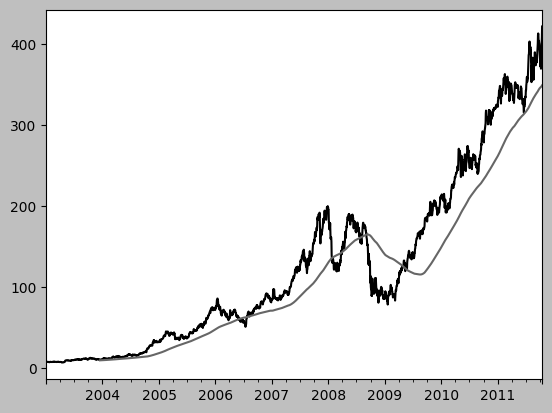

In [166]:
close_px["AAPL"].plot()
close_px["AAPL"].rolling(250).mean().plot()

The expression `rolling(250)` is similar in behavior to `groupby`, but instead of grouping, it creates an object that enables grouping over a 250-day sliding window. So here we have the 250-day moving window average of Apple's stock price.

By default, rolling functions require all of the values in the window to be non-NA. This behavior can be changed to account for missing data and, in particular, the fact that you will have fewer than `window` periods of data at the beginning of the time series (see below figure):

In [165]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [157]:
std250 = close_px["AAPL"].pct_change().rolling(250, min_periods=10).std()
std250[5:12]

2003-01-09         NaN
2003-01-10         NaN
2003-01-13         NaN
2003-01-14         NaN
2003-01-15         NaN
2003-01-16    0.009628
2003-01-17    0.013818
Freq: B, Name: AAPL, dtype: float64

<AxesSubplot: >

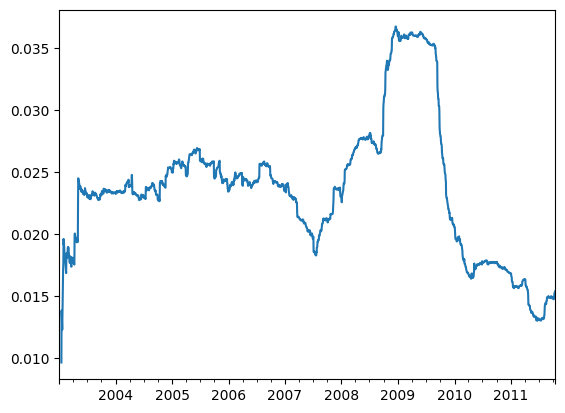

In [158]:
std250.plot()

To compute an expanding window mean, use the `expanding` operator instead of `rolling`. The expanding mean starts the time window from the same point as the rolling window and increases the size of the window until it encompasses the whole series. An expanding window mean on the `std250` time series looks like this:

In [159]:
expanding_mean = std250.expanding().mean()

Calling a moving window function on a DataFrame applies the transformation to each column (see below figure):

<AxesSubplot: >

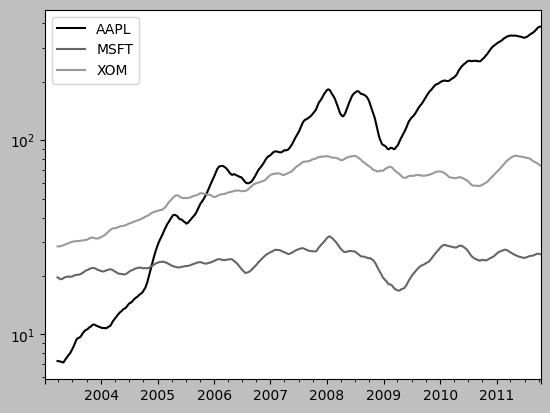

In [160]:
plt.style.use('grayscale')

close_px.rolling(60).mean().plot(logy=True)

The `rolling` function also accepts a string indicating a fixed-size time offset rolling() in moving window functions rather than a set number of periods. Using this notation can be useful for irregular time series. These are the same strings that you can pass to `resample`. For example, we could compute a 20-day rolling mean like so:

In [161]:
close_px.rolling("20D").mean()

,AAPL,MSFT,XOM
2003-01-02,7.400000,21.110000,29.220000
2003-01-03,7.425000,21.125000,29.230000
2003-01-06,7.433333,21.256667,29.473333
2003-01-07,7.432500,21.425000,29.342500
2003-01-08,7.402000,21.402000,29.240000
...,...,...,...
2011-10-10,389.351429,25.602143,72.527857
2011-10-11,388.505000,25.674286,72.835000
2011-10-12,388.531429,25.810000,73.400714
2011-10-13,388.826429,25.961429,73.905000


<h2>Exponentially Weighted Functions</h2>

An alternative to using a fixed window size with equally weighted observations is to specify a constant decay factor to give more weight to more recent observations. There are a couple of ways to specify the decay factor. A popular one is using a span, which makes the result comparable to a simple moving window function with window size equal to the span.

Since an exponentially weighted statistic places more weight on more recent observations, it “adapts” faster to changes compared with the equal-weighted version.

pandas has the `ewm` operator (which stands for exponentially weighted moving) to go along with `rolling` and `expanding`. Here’s an example comparing a 30-day moving average of Apple’s stock price with an exponentially weighted (EW) moving average with `span=60` (see below figure):

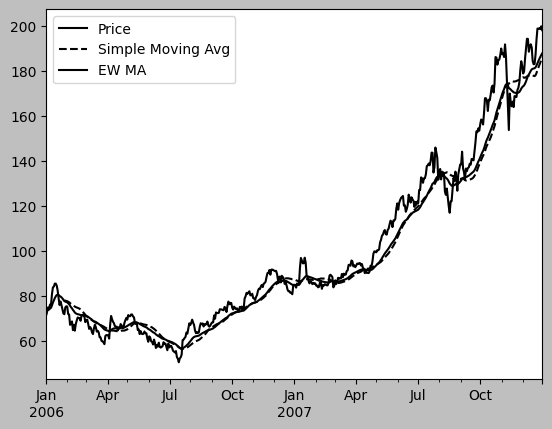

In [167]:
aapl_px = close_px["AAPL"]["2006":"2007"]

ma30 = aapl_px.rolling(30, min_periods=20).mean()
ewma30 = aapl_px.ewm(span=30).mean()

aapl_px.plot(style="k-", label="Price")
ma30.plot(style="k--", label="Simple Moving Avg")
ewma30.plot(style="k-", label="EW MA")

plt.legend()

<h2>Binary Moving Window Functions</h2>

Some statistical operators, like correlation and covariance, need to operate on two time series. As an example, financial analysts are often interested in a stock’s correlation to a benchmark index like the S&P 500. To have a look at this, we first compute the percent change for all of our time series of interest:

In [ ]:
spx_px = close_px_all["SPX"]
spx_rets = spx_px.pct_change()
returns = close_px.pct_change()

After we call `rolling`, the `corr` aggregation function can then compute the rolling correlation with `spx_rets` (see below figure for the resulting plot):

<AxesSubplot: >

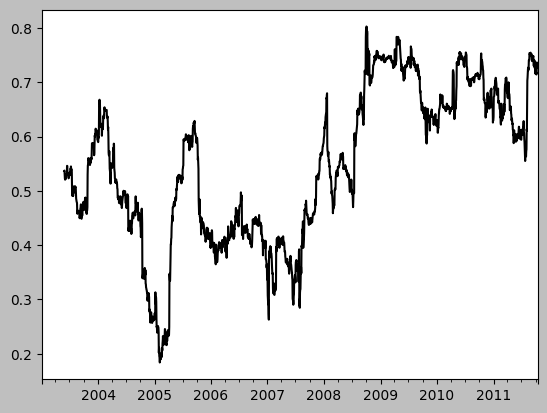

In [ ]:
corr = returns["AAPL"].rolling(125, min_periods=100).corr(spx_rets)

corr.plot()

Suppose you wanted to compute the rolling correlation of the S&P 500 index with many stocks at once. You could write a loop computing this for each stock like we did for Apple above, but if each stock is a column in a single DataFrame, we can compute all of the rolling correlations in one shot by calling `rolling` on the DataFrame and passing the `spx_rets` Series.

See below figure for the plot of the result:

<Figure size 640x480 with 0 Axes>

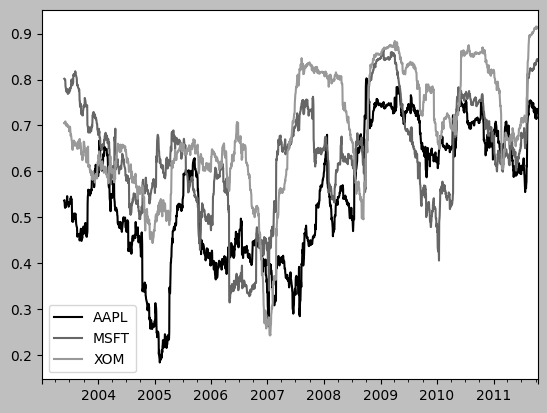

<Figure size 640x480 with 0 Axes>

In [ ]:
corr = returns.rolling(125, min_periods=100).corr(spx_rets)

corr.plot()

plt.figure()

<h2>User-Defined Moving Window Functions</h2>

The `apply` method on `rolling` and related methods provides a way to apply an array function of your own creation over a moving window. The only requirement is that the function produce a single value (a reduction) from each piece of the array. For example, while we can compute sample quantiles using `rolling(...).quantile(q)`, we might be interested in the percentile rank of a particular value over the sample. The `scipy.stats.percentileofscore` function does just this (see Figure below figure for the resulting plot):

<AxesSubplot: >

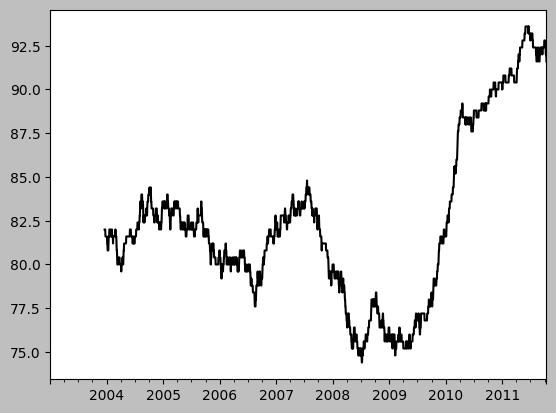

In [ ]:
from scipy.stats import percentileofscore

def score_at_2percent(x):
    return percentileofscore(x, 0.02)

result = returns["AAPL"].rolling(250).apply(score_at_2percent)

result.plot()